<a href="https://colab.research.google.com/github/Nusserle/sentiment_learning/blob/master/conceptnet_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [2]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())
pool = mp.Pool(mp.cpu_count())
!pip install git+https://github.com/crazyfrogspb/RedditScore.git
!sudo apt-get -o Dpkg::Options::="--force-confmiss" install --reinstall netbase
!python -c "import socket ; socket.getprotobyname('udp')"

     |████████████████████████████████| 51kB 1.5MB/s 
     |████████████████████████████████| 225kB 10.0MB/s 
     |████████████████████████████████| 194kB 45.6MB/s 
  Created wheel for redditscore: filename=redditscore-0.7.3-cp36-none-any.whl size=7649186 sha256=b819827feafac1aa90a29a1ff76ca52eac228e305315f7104ab77ffed0130553
  Stored in directory: /tmp/pip-ephem-wheel-cache-z0zpg3k9/wheels/54/c4/ea/7d0f96ecd8eaf8783eab55e0d21094496fe58c9104f0916b5a
  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7099 sha256=f3ccb95bf6432d2957486b57e94351bb77f35869a85fa917ec70efdd0a59c754
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built redditscore adjustText
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
Th

In [3]:
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from redditscore.tokenizer import CrazyTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Functions**

In [0]:
import re
rule0 = re.compile(r'\$&@\*#')
rule1 = re.compile(r"\s.*?twitter.*?\s")
rule2= re.compile(r'social_autopilot&utm_source')
rule3= re.compile(r'tweet&utm_medium')



def read_in(path_to_file):
    """
    Reads in training and test data and removes all neutral tweets
    from test data because the training data lacks neutral.
    Due to hardware restrictions we used only 1/10th of the available 
    training dataset (160.000 tweets)
    """
    out = []
    with open(path_to_file, encoding='latin-1') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            out.append([row[1], row[2]])
    return out

def read_in2(path_to_file):
  out = []
  with open(path_to_file, encoding='latin-1') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
          if row.__len__() > 0:
            out.append([row[0], row[1]])
  return out


def preprocess(data):
    """
    Preprocesses and tokenizes data
    """
    label = []
    tweet = []
    lemmatizer = WordNetLemmatizer()
    tk = CrazyTokenizer(lowercase=True, keepcaps=False, normalize=2, ignore_quotes=False, ignore_reddit_quotes=False, ignore_stopwords='english', 
                        stem='lemm', remove_punct=True, remove_breaks=True, decontract=True, twitter_handles='', urls='url', hashtags='split', 
                        numbers=False, subreddits=False, reddit_usernames=False, emails=False, 
                        extra_patterns=[('rule0', rule0, 'stupid'), ('rule1', rule1, 'url'), ('rule2', rule2, ''), ('rule3', rule3, '')], 
                        keep_untokenized=None, whitespaces_to_underscores=True, 
                        remove_nonunicode=True, pos_emojis=True, neg_emojis=True, neutral_emojis=True, print_url_warnings=False, 
                        latin_chars_fix=True, ngrams=1)
    print("Preprocessing...")
    for i, row in enumerate(data):
      if i % 100 == 0:
        print(i)
      cleaned = clean_regex(row[1])
      if cleaned.__len__() > 1:
          if row[0] == "0":
              label.append(0)
          else:
              label.append(1)
          lemmatized = tk.tokenize(row[1])
          #tokenized = nltk.word_tokenize(cleaned)
          #lemmatized = []
          #for w in tokenized:
            #lemmatized.append(lemmatizer.lemmatize(w))
          # pos_tagged = nltk.pos_tag(tokenized)
          tweet.append(lemmatized)
    print("Done")
    return tweet, label

def preprocess2(data):
    """
    Preprocesses and tokenizes data
    """
    ids = []
    tweet = []
    lemmatizer = WordNetLemmatizer()
    tk = CrazyTokenizer(lowercase=True, keepcaps=False, normalize=2, ignore_quotes=False, ignore_reddit_quotes=False, ignore_stopwords='english', 
                        stem='lemm', remove_punct=True, remove_breaks=True, decontract=True, twitter_handles='', urls='url', hashtags='split', 
                        numbers=False, subreddits=False, reddit_usernames=False, emails=False, 
                        extra_patterns=[('rule0', rule0, 'stupid'), ('rule1', rule1, 'url'), ('rule2', rule2, ''), ('rule3', rule3, '')], 
                        keep_untokenized=None, whitespaces_to_underscores=True, 
                        remove_nonunicode=True, pos_emojis=True, neg_emojis=True, neutral_emojis=True, print_url_warnings=False, 
                        latin_chars_fix=True, ngrams=1)
    print("Preprocessing...")
    for i, row in enumerate(data):
      if i % 100 == 0:
        print(i)
      cleaned = clean_regex(row[1])
      if cleaned.__len__() > 1:
        lemmatized = tk.tokenize(row[1])

          #tokenized = nltk.word_tokenize(cleaned)
          #lemmatized = []
          #for w in tokenized:
            # lemmatized.append(lemmatizer.lemmatize(w))
          # pos_tagged = nltk.pos_tag(tokenized)
        tweet.append(lemmatized)
        ids.append(row[0])
    print("Done")
    return tweet, ids


def clean_regex(tweet):
    """
    Regex that removes links to other users, and all hyperlink mentions
    """
    hashtags = re.findall('#[a-z]*?[A-Z][A-Z|a-z]*', tweet)
    for hashtag in hashtags:
      replacement = ' '.join(re.sub( r"([A-Z])", r" \1", hashtag).split())
      tweet = tweet.replace(hashtag, replacement).lower()
    cleaned0 = re.sub('\$&@\*#', 'fuck', tweet)
    cleaned1 = re.sub('@.*?(?:\s|$)', '', cleaned0)
    cleaned2 = re.sub('http.*?(?:\s|$)', '', cleaned1)
    cleaned3 = re.sub('www.*?(?:\s|$)', '', cleaned2)
    cleaned4 = re.sub('#','', cleaned3)
    return cleaned4

def parse_to_dict(file_path):
    """
    Creates hashmap with word as key and concept vector as value
    :param file_path: path to the conceptnet dictionary file
    :return: hashmap of word and vectors
    """
    concept_hash = {}
    with open(file_path, encoding="utf8") as f:
        text = f.readlines()[1:]
        for line in text:
            first_item = line.split(" ").__getitem__(0)
            concept_hash[first_item] = line
    f.close()
    return concept_hash

def find_word(word, concept_hash, lower=True):
    """
    Finds conceptnet vector for a word in the conceptnet hashmap
    :param word: input word to analyze
    :param concept_hash: hashmap of word and conceptnet vector
    :return: returns the appropriate vector or none if its not in the hashmap
    """
    if lower:
      word = word.lower()
    if word in concept_hash.keys():
        #vector = list(concept_hash[word])
        vector = concept_hash[word].split(" ")[1:]
        vector = [float(i) for i in vector]
    else:
        vector = None
    return vector
  
def get_embeddings(sentences, embedding_vectors, max_words=57):
    """
    Retrieves a 300 dim. embedding vector from ConceptNet for each word 
    of a sentence. (Only retrieves the first 40 words (tokens) of a tweet)
    """
    results = np.zeros((len(sentences), max_words, 300))
    for i, sent in enumerate(sentences):
        if i % 25000 == 0:
            print(str(i))
        local_max = 0
        for j, word in enumerate(sent):
            if j < max_words:
                embedding = find_word(word.lower(), embedding_vectors)
                if embedding is not None:
                    local_max += 1
                    for k, val in enumerate(embedding):
                        results[i][j][k] = val
                else:
                    for k in range(300):
                        results[i][j][k] = 0.0
        #sentence_sentiment = sid.polarity_scores(' '.join(sent))['compound']
        #if sentence_sentiment > 0:
        #  results[i][57] = 1.0
        #elif sentence_sentiment < 0:
        #  results[i][57] = -1.0
        #else:
        #  results[i][57] = 0.0
    return results

def fill_list(data, max_dim=60):
  """
  Fills or cuts list of tokens for a tweet at 35, to ensure consistent vector dimensions
  """
  res = []
  for row in data:
      copy = row
      if len(row) < max_dim:
          copy += [''] * (max_dim - len(row))
      elif len(row) > max_dim:
          copy = row[:max_dim]   
      res.append(copy)
  return res

#def write_to_file(file_name, data, label):
#  f= open("preprocessed","w+")


In [30]:
from google.colab import files
files.upload()

Saving train_2kmZucJ.csv to train_2kmZucJ.csv
Saving test_oJQbWVk.csv to test_oJQbWVk.csv


{'test_oJQbWVk.csv': b'id,tweet\r\n7921,I hate the new #iphone upgrade. Won\'t let me download apps. #ugh #apple sucks\r\n7922,currently shitting my fucking pants. #apple #iMac #cashmoney #raddest #swagswagswag http://instagr.am/p/UUIS0bIBZo/\r\n7923,"I\'d like to puts some CD-ROMS on my iPad, is that possible?\' \xe2\x80\x94 Yes, but wouldn\'t that block the screen?\n"\r\n7924,"My ipod is officially dead. I lost all my pictures and videos from the 1D and 5sos concert,and from Vet Camp #hatinglife #sobbing"\r\n7925,Been fighting iTunes all night! I only want the music I $&@*# paid for\r\n7926,#Repost @getbakednfried with repostapp \xe3\x83\xbb\xe3\x83\xbb\xe3\x83\xbb to announce we will have our #apple #bourbon\xe2\x80\xa6 https://www.instagram.com/p/BK5okHOgWSS/\r\n7927,This new apple software update is really doing things to my phone. Bad things apple\r\n7928,BABY #iPhone #iphone6s #gold #new #apple #appleisbest #64GB #geg\xc3\xb6nnt #aaaaah https://www.instagram.com/p/BAUx8eQtKez/\r

In [0]:
!git clone https://github.com/HIT-SCIR/ELMoForManyLangs
!pip install allennlp
%cd ELMoForManyLangs/
%ls
!python setup.py install
!wget http://vectors.nlpl.eu/repository/11/144.zip
!unzip 144.zip
%rm "config.json"

In [12]:
from google.colab import files
files.upload()

{}

In [0]:
%cd ..
from elmoformanylangs import Embedder
e = Embedder('ELMoForManyLangs/')

In [0]:
pip install bert-embedding
from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding()

In [0]:
bert_embedding(["This is a test sentence", "This as well"] )

**Preprocessing**

In [0]:

file = !wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz
  
import gzip
import shutil
with gzip.open("numberbatch-en-17.06.txt.gz",'rb') as f_in:
    with open('numberbatch-en.txt','wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


In [0]:
concept_hash = parse_to_dict("numberbatch-en.txt")

In [0]:
pool = mp.Pool(mp.cpu_count())
mp.cpu_count
#base_path = "C:/Users/Tobias.Nusser/PycharmProjects/sentiment_learning"
#base_path = os.getcwd()
# 140.000 entries
data = read_in("train_2kmZucJ.csv")
print(data.__len__())
data_1 = data[:2000]
data_2 = data[2000:4000]
data_3 = data[4000:6000]
data_4 = data[6000:]

res_data_1 = pool.apply_async(preprocess, args=(data_1,))
res_data_2 = pool.apply_async(preprocess, args=(data_2,))
res_data_3 = pool.apply_async(preprocess, args=(data_3,))
res_data_4 = pool.apply_async(preprocess, args=(data_4,))

t1, l1 = res_data_1.get()
t2, l2 = res_data_2.get()
t3, l3 = res_data_3.get()
t4, l4 = res_data_4.get()

training_data = t1 + t2 + t3 + t4
training_label = l1 + l2 + l3 + l4


#training_data = pool.apply_async(preprocess, args=(data,))
#output = training_data.get()
#training_data, training_label = 
#test_data, test_label = preprocess2(read_in2("test_oJQbWVk.csv"))
#print(training_data)

In [0]:
zipped = list(zip(training_data, training_label))
with open("preprocessed.txt", mode='w') as fi:
  for el in zipped:
    fi.write(str(el))

In [15]:
from google.colab import files
files.upload() 

Saving testdata_processed.txt to testdata_processed.txt
Saving preprocessed.txt to preprocessed.txt


{'preprocessed.txt': b'([\'fingerprint\', \'pregnancy\', \'test\', \'url\', \'android\', \'apps\', \'beautiful\', \'cute\', \'health\', \'ige\', \'rs\', \'iphone\', \'only\', \'iphone\', \'sia\', \'iphone\'], 0)([\'finally\', \'transparant\', \'silicon\', \'case\', \'^^\', \'thanks\', \'uncle\', \'yay\', \'sony\', \'xperia\', \'s\', \'sony\', \'ex\', \'peri\', \'as\', \'url\'], 0)([\'love\', \'would\', \'go\', \'talk\', \'make\', \'memories\', \'unplug\', \'relax\', \'iphone\', \'smartphone\', \'wifi\', \'connect\', \'url\'], 0)([\'wired\', \'know\', \'george\', \'made\', \'way\', \'iphone\', \'cute\', \'daventry\', \'home\', \'url\'], 0)([\'amazing\', \'service\', \'apple\', \'even\', \'talk\', \'question\', \'unless\', \'pay\', \'$\', \'19.95\', \'stupid\', \'support\'], 1)([\'iphone\', \'software\', \'update\', \'fucked\', \'phone\', \'big\', \'time\', \'stupid\', \'iphones\'], 1)([\'happy\', \'u\', \'in\', \'st\', \'apic\', \'insta\', \'daily\', \'us\', \'sony\', \'xperia\', \'xpe\

In [0]:
with open("preprocessed.txt", mode="r") as fi:
  for line in fi.readlines():
    tuples = line.split(")(")
tuples[0] = tuples[0].replace("(","")
tuples[-1] = tuples[-1].replace(")","")


In [0]:
import ast
import re
training_label = []
training_data = []
for tup in tuples:
  m = re.search('(, [0|1])', tup)
  if m:
    found = m.group(1)
    training_label.append(found.replace(", ", ""))
  tup_cut = tup.replace(found, "")
  train_row = ast.literal_eval(tup_cut)
  training_data.append(train_row)


In [159]:
zipped = list(zip(training_data, training_label))
random.shuffle(zipped)
print(zipped)
training_data = []
training_label = []
for tup in zipped:
  training_data.append(tup[0])
  training_label.append(tup[1])

[(['get', 'io', '7', 'reason', 'sure', 'getting', 'io', '7.2', 'apple'], '1'), (['happy', 'baby', 'instagram', 'iphone', '4', 's', 'iphone', 'og', 'raphy', 'apple', 'brother', 'baby', 'cute', 'smile', 'url'], '0'), (['achi', 'favorite', 'gon', 'na', 'die', 'sure', 'samsung', 'live', 'laugh', 'life', 'kinder', 'dxb', 'url'], '0'), (['hard', 'plastic', 'shaw', 'much', 'zeta', 'supply', 'click', 'link', 'url', 'utm_campaign', '=', 'social_autopilot&utm_source', '=', '=', 'tweet', 'iphone', 'discount', 'case'], '0'), (['iphone', 'macbook', 'pro', 'owned', 'many', 'ipod', 'past', 'product', 'great', 'company', 'evil'], '1'), (['blow', 'phone', 'like', 'nintendo', 'video', 'cartridge', 'charge', 'apple', 'iphone'], '1'), (['iphone', 'slowly', 'braking', 'screen', 'cracked', 'charge'], '1'), (['heard', 'mary', 'soundcloud', 'np', 'url', 'utm_source', '=', 'soundcloud&utm_campaign', '=', 'share&utm_medium', '=', 'twitter', '#a&r', 'sony', 'universal', 'polydor', 'music', 'industry', 'singer'],

In [8]:
r_set = {}
for row in training_data:
  if row.__len__() not in r_set:
    r_set[row.__len__()] = 1
  else:
    r_set[row.__len__()] = r_set[row.__len__()] + 1
import operator
sorted_x = sorted(r_set.items(), key=operator.itemgetter(0), reverse=True)
print(sorted_x)

[(57, 2), (56, 2), (55, 1), (52, 1), (51, 2), (50, 2), (49, 4), (48, 1), (47, 6), (46, 5), (45, 7), (44, 6), (43, 10), (42, 14), (41, 11), (40, 15), (39, 15), (38, 21), (37, 30), (36, 29), (35, 37), (34, 39), (33, 47), (32, 30), (31, 38), (30, 48), (29, 36), (28, 28), (27, 33), (26, 32), (25, 39), (24, 59), (23, 45), (22, 61), (21, 73), (20, 136), (19, 249), (18, 248), (17, 380), (16, 591), (15, 729), (14, 762), (13, 746), (12, 844), (11, 647), (10, 558), (9, 445), (8, 335), (7, 194), (6, 139), (5, 50), (4, 31), (3, 5), (1, 1), (0, 1)]


In [0]:
combined = training_data + test_data
dic = {}
for l in combined:
  for e in l:
    if e not in dic:
      dic[e] = 1
    else:
      dic[e] = dic[e] + 1
import operator
sorted_x = sorted(dic.items(), key=operator.itemgetter(1), reverse=True)

for entry in sorted_x:
  print(entry)

**Split into training and validation set**

In [0]:
split_at = 7000
train_data = training_data[:split_at]
train_label = np.asarray(training_label[:split_at])
val_data = training_data[split_at:]
val_label = np.asarray(training_label[split_at:])

In [0]:
train_embedding_matrix = np.asarray(e.sents2elmo(fill_list(train_data)))
val_embedding_matrix = np.asarray(e.sents2elmo(fill_list(val_data)))

In [0]:
out_array = np.zeros(shape=(train_data.__len__(),10,768))
for i, row in enumerate(train_data):
  if i % 5 == 0:
    print(i)
  vec = bert_embedding(row)
  for j, word_vec in enumerate(vec):
    if j < 10:
      out_array[i][j] = word_vec[1][0]
  #print(type(bert_embedding(row)[0]))
#train_embedding_matrix = bert_embedding(fill_list(train_data))
#val_embedding_matrix = bert_embedding(fill_list(val_data))

**Retrieve word embedding vectors for training and validation data**

In [161]:
train_embedding_matrix = get_embeddings(train_data, concept_hash, max_words=57)
val_embedding_matrix = get_embeddings(val_data, concept_hash, max_words=57)
#new_train_embedding_matrix = np.concatenate((train_embedding_matrix, train_embedding_matrix2), axis=1)
#new_val_embedding_matrix = np.concatenate((val_embedding_matrix, val_embedding_matrix2), axis=1)


0
0


In [13]:
print(train_embedding_matrix.shape)

(7000, 35, 300)


In [0]:
elmo_train_embedding_matrix = train_embedding_matrix
elmo_val_embedding_matrix = val_embedding_matrix

In [38]:
print(train_embedding_matrix[5][5])
print(train_embedding_matrix[0][0].__len__())
print(train_embedding_matrix.shape)
print(val_embedding_matrix.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
300
(7000, 23, 300)
(920, 23, 300)


In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')



**Neural Network Model**

Sequential model with three Dense Layers and one Flatten layer to flatten 3D input matrix.
*Relu* as activation function and simple *sigmoid* function for the output layer. Because of the binary classification task we used a simple *accuracy* metric and *binary crossentropy* as loss function. As optimizer we used *rmsprop*, which performed best according to some tests.

In [162]:
from keras.callbacks import ModelCheckpoint

model = models.Sequential()
model.add(layers.LSTM(57, activation='tanh' ,input_shape=(57,300,)))
#model.add(layers.Dense(64, activation='relu' ,input_shape=(57,300,)))
#model.add(layers.Conv1D(64, 5, activation='relu',input_shape=(57,300,)))
#model.add(layers.GlobalMaxPooling1D())
#model.add(layers.GRU(64, activation='tanh', input_shape=(57,300,)))
#model.add(layers.Flatten())
model.add(layers.Dense(57, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
print(model.summary())
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(train_embedding_matrix,
                    train_label,
                    epochs=65,
                    batch_size=512,
                    validation_data=(val_embedding_matrix, val_label), verbose=1, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 57)                81624     
_________________________________________________________________
dense_47 (Dense)             (None, 57)                3306      
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 58        
Total params: 84,988
Trainable params: 84,988
Non-trainable params: 0
_________________________________________________________________
None
Train on 7000 samples, validate on 920 samples
Epoch 1/65
7000/7000 [==============================] - 7s 1ms/step - loss: 0.6190 - acc: 0.7111 - val_loss: 0.4729 - val_acc: 0.7565

Epoch 00001: val_acc improved from -inf to 0.75652, saving model to weights.best.hdf5
Epoch 2/65
7000/7000 [==============================] - 5s 668us/step - loss: 0.4078 - acc: 0.7570 - val_loss: 0.3482 - val_acc: 

In [163]:
from keras.callbacks import ModelCheckpoint

model2 = models.Sequential()
#model2.add(layers.LSTM(57, activation='tanh' ,input_shape=(57,300,)))
model2.add(layers.Dense(57, activation='relu' ,input_shape=(57,300,)))
#model.add(layers.Conv1D(64, 5, activation='relu',input_shape=(57,300,)))
#model.add(layers.GlobalMaxPooling1D())
#model.add(layers.GRU(64, activation='tanh', input_shape=(57,300,)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(38, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
print(model2.summary())
filepath="weights2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model2.fit(train_embedding_matrix,
                    train_label,
                    epochs=45,
                    batch_size=512,
                    validation_data=(val_embedding_matrix, val_label), verbose=1, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 57, 57)            17157     
_________________________________________________________________
flatten_11 (Flatten)         (None, 3249)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 3249)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 38)                123500    
_________________________________________________________________
dropout_10 (Dropout)         (None, 38)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 16)                624       
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 17        
Total para

In [189]:
from keras.callbacks import ModelCheckpoint

model2 = models.Sequential()
model2.add(layers.LSTM(57, activation='tanh' ,input_shape=(57,300,), return_sequences=True))
model2.add(layers.Dropout(0.5))
model2.add(layers.LSTM(57, activation='tanh' ,input_shape=(57,300,)))
#model2.add(layers.Dense(64, activation='relu' ,input_shape=(57,300,)))
#model2.add(layers.Conv1D(64, 5, activation='relu',input_shape=(57,300,)))
#model2.add(layers.GlobalMaxPooling1D())
#model2.add(layers.GRU(64, activation='tanh', input_shape=(57,300,)))
#model2.add(layers.Flatten())
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
print(model2.summary())
filepath="weights2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model2.fit(train_embedding_matrix,
                    train_label,
                    epochs=65,
                    batch_size=512,
                    validation_data=(val_embedding_matrix, val_label), verbose=1, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 57, 57)            81624     
_________________________________________________________________
dropout_11 (Dropout)         (None, 57, 57)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 57)                26220     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 58        
Total params: 107,902
Trainable params: 107,902
Non-trainable params: 0
_________________________________________________________________
None
Train on 7000 samples, validate on 920 samples
Epoch 1/65
7000/7000 [==============================] - 12s 2ms/step - loss: 0.5910 - acc: 0.7330 - val_loss: 0.4769 - val_acc: 0.7565

Epoch 00001: val_acc improved from -inf to 0.75652, saving model to weights2.bes

In [201]:
from keras.callbacks import ModelCheckpoint

model3 = models.Sequential()
model3.add(layers.GRU(57, activation='tanh' ,input_shape=(57,300,), return_sequences=True))
model3.add(layers.Dropout(0.25))
model3.add(layers.GRU(57, activation='tanh' ,input_shape=(57,300,)))
#model3.add(layers.Dense(64, activation='relu' ,input_shape=(57,300,)))
#model3.add(layers.Conv1D(64, 5, activation='relu',input_shape=(57,300,)))
#model3.add(layers.GlobalMaxPooling1D())
#model3.add(layers.GRU(64, activation='tanh', input_shape=(57,300,)))
#model3.add(layers.Flatten())
model3.add(layers.Dense(1, activation='sigmoid'))
model3.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
print(model3.summary())
filepath="weights3.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model3.fit(train_embedding_matrix,
                    train_label,
                    epochs=65,
                    batch_size=512,
                    validation_data=(val_embedding_matrix, val_label), verbose=1, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 57, 57)            61218     
_________________________________________________________________
dropout_12 (Dropout)         (None, 57, 57)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 57)                19665     
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 58        
Total params: 80,941
Trainable params: 80,941
Non-trainable params: 0
_________________________________________________________________
None
Train on 7000 samples, validate on 920 samples
Epoch 1/65
7000/7000 [==============================] - 10s 1ms/step - loss: 0.6076 - acc: 0.7423 - val_loss: 0.5660 - val_acc: 0.7565

Epoch 00001: val_acc improved from -inf to 0.75652, saving model to weights3.best.

In [173]:
from keras.callbacks import ModelCheckpoint

model3 = models.Sequential()
#model2.add(layers.LSTM(57, activation='tanh' ,input_shape=(57,300,)))
#model3.add(layers.Dense(57, activation='relu' ,input_shape=(57,300,)))
model3.add(layers.Conv1D(64, 5, activation='relu',input_shape=(57,300,)))
model3.add(layers.GlobalMaxPooling1D())
#model.add(layers.GRU(64, activation='tanh', input_shape=(57,300,)))
#model3.add(layers.Flatten())
model3.add(layers.Dense(57, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
print(model3.summary())
filepath="weights3.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model3.fit(train_embedding_matrix,
                    train_label,
                    epochs=16,
                    batch_size=512,
                    validation_data=(val_embedding_matrix, val_label), verbose=1, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 53, 64)            96064     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 57)                3705      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 58        
Total params: 99,827
Trainable params: 99,827
Non-trainable params: 0
_________________________________________________________________
None
Train on 7000 samples, validate on 920 samples
Epoch 1/16
7000/7000 [==============================] - 6s 816us/step - loss: 0.4747 - acc: 0.7624 - val_loss: 0.3694 - val_acc: 0.8337

Epoch 00001: val_acc improved from -inf to 0.83370, saving model to weights3.best

**Plotting accuracy and loss in the training phase**

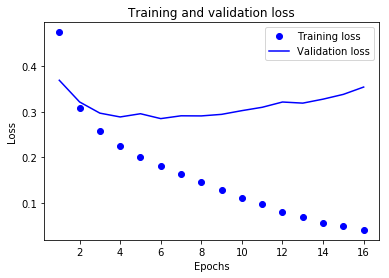

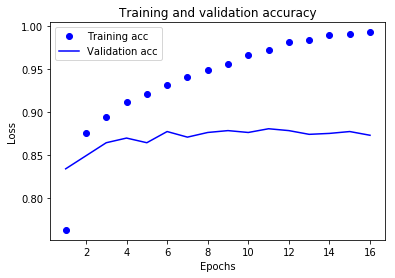

In [180]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluating model on test data**

In [0]:
test_label = np.asarray(test_label)
#test_embedding_matrix = get_embeddings(test_data)
test_embedding_matrix = np.asarray(e.sents2elmo(fill_list(test_data)))
results = model.evaluate(test_embedding_matrix, test_label)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

359/359 [==============================] - 0s 140us/step
Loss:  0.6674792934260992
Accuracy:  0.7047353763766275


In [0]:
elmo_test_embedding_matrix = test_embedding_matrix

In [0]:
test_data, test_id = preprocess2(read_in2("test_oJQbWVk.csv"))

#test_embedding_matrix = np.asarray(e.sents2elmo(fill_list(test_data)))
print(test_embedding_matrix.shape)

Preprocessing...
Done
0
(1953, 60, 300)


In [0]:
test_embedding_matrix = get_embeddings(test_data)

0


In [29]:
%ls

numberbatch-en-17.06.txt.gz  preprocessed.txt  testdata_processed.txt
numberbatch-en.txt           sample_data/      weights.best.hdf5


In [31]:
pool = mp.Pool(mp.cpu_count())
mp.cpu_count
test_data = read_in2("test_oJQbWVk.csv")
print(test_data.__len__())
test_1 = test_data[:500]
test_2 = test_data[500:1000]
test_3 = test_data[1000:1500]
test_4 = test_data[1500:]

res_test_1 = pool.apply_async(preprocess2, args=(test_1,))
res_test_2 = pool.apply_async(preprocess2, args=(test_2,))
res_test_3 = pool.apply_async(preprocess2, args=(test_3,))
res_test_4 = pool.apply_async(preprocess2, args=(test_4,))

t1, l1 = res_test_1.get()
t2, l2 = res_test_2.get()
t3, l3 = res_test_3.get()
t4, l4 = res_test_4.get()

test_data = t1 + t2 + t3 + t4
test_label = l1 + l2 + l3 + l4

1953
Preprocessing...
0
Preprocessing...
0
Preprocessing...
Preprocessing...
0
0
100
100
100
100
200
200
200
200
300
300
300
300
400
400
400
400
Done
Done
Done
Done


In [0]:
zipped = list(zip(test_data, test_label))
with open("testdata_processed.txt", mode='w') as fi:
  for el in zipped:
    fi.write(str(el))
from google.colab import files
files.download("testdata_processed.txt") 

In [0]:
with open("testdata_processed.txt", mode="r") as fi:
  for line in fi.readlines():
    tuples = line.split(")(")
tuples[0] = tuples[0].replace("(","")
tuples[-1] = tuples[-1].replace(")","")
import ast
import re
test_label = []
test_data = []
for tup in tuples:
  m = re.search('(, [0|1])', tup)
  if m:
    found = m.group(1)
    test_label.append(found.replace(", ", ""))
  tup_cut = tup.replace(found, "")
  test_row = ast.literal_eval(tup_cut)
  test_data.append(test_row)

In [27]:
print(test_data)
print(test_label)

[(['fingerprint', 'pregnancy', 'test', 'url', 'android', 'apps', 'beautiful', 'cute', 'health', 'ige', 'rs', 'iphone', 'only', 'iphone', 'sia', 'iphone'], '0'), (['finally', 'transparant', 'silicon', 'case', '^^', 'thanks', 'uncle', 'yay', 'sony', 'xperia', 's', 'sony', 'ex', 'peri', 'as', 'url'], '0'), (['love', 'would', 'go', 'talk', 'make', 'memories', 'unplug', 'relax', 'iphone', 'smartphone', 'wifi', 'connect', 'url'], '0'), (['wired', 'know', 'george', 'made', 'way', 'iphone', 'cute', 'daventry', 'home', 'url'], '0'), (['amazing', 'service', 'apple', 'even', 'talk', 'question', 'unless', 'pay', '$', '19.95', 'stupid', 'support'], '1'), (['iphone', 'software', 'update', 'fucked', 'phone', 'big', 'time', 'stupid', 'iphones'], '1'), (['happy', 'u', 'in', 'st', 'apic', 'insta', 'daily', 'us', 'sony', 'xperia', 'xpe', 'riaz', 'url'], '0'), (['new', 'type', 'c', 'charger', 'cable', 'uk', 'url', 'bay', 'amazon', 'etsy', 'new', 'year', 'rob', 'cross', 'to', 'by', 'young', 'eve', 'mun', '

In [34]:

test_embedding_matrix = get_embeddings(test_data, concept_hash, max_words=57)

0


In [0]:
model.load_weights("weights.best.hdf5")
model2.load_weights("weights2.best.hdf5")
model3.load_weights("weights3.best.hdf5")

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 36)                48528     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 37        
Total params: 48,565
Trainable params: 48,565
Non-trainable params: 0
_________________________________________________________________


In [0]:
prediction1 = model.predict(test_embedding_matrix)
prediction2 = model2.predict(test_embedding_matrix)
prediction3 = model3.predict(test_embedding_matrix)

In [117]:
print(prediction.__len__())

1953


In [209]:
output = []
prediction_sum = np.zeros(prediction1.__len__())
from statistics import mean
for j, l in enumerate(prediction1):
  tmp = []
  tmp.append(float(prediction1[j][0]))
  tmp.append(float(prediction2[j][0]))
  tmp.append(float(prediction3[j][0]))
  sum = 0
  for a in tmp:
    sum += a
  prediction_sum[j] = sum/3
print(prediction_sum)
for i, pred in enumerate(prediction_sum):
  if pred > 0.5:
    output.append([test_label[i], "1"])
  else:
    output.append([test_label[i], "0"])
with open('output.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerow(["id", "label"])
    writer.writerows(output)


[0.89069168 0.3358547  0.87076259 ... 0.73720121 0.82450271 0.00165578]


In [0]:
output = []
for i, pred in enumerate(prediction3):
  if pred > 0.5:
    output.append([test_label[i], "1"])
  else:
    output.append([test_label[i], "0"])
with open('output.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerow(["id", "label"])
    writer.writerows(output)

In [210]:
%ls
from google.colab import files
files.download('output.csv')

numberbatch-en-17.06.txt.gz  sample_data/            weights2.best.hdf5
numberbatch-en.txt           testdata_processed.txt  weights3.best.hdf5
output.csv                   test_oJQbWVk.csv        weights.best.hdf5
preprocessed.txt             train_2kmZucJ.csv


**Results**

We trained our network on 140.000 samples (120.000 training and 20.000 validation samples) and used the word embedding vectors obtained by ConceptNet. Unfortunately, due to hardware limitations, this is less than a 10th of the available training data. However, as we tested the model with multiple random subsets of the 1.6M samples we achieved accuracies in-between 78%-82%, and therefore perform as good as several state-of-the-art approaches [Go et al.](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf), [Ebert et al.](https://www.aclweb.org/anthology/W15-2915). Accuracy and loss improve until epoch 6-10 and more or less stagnate until epoch 20.